In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

In [261]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [262]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

## Reading the regression table

From latex to pandas

In [264]:
from astropy.table import Table
tab = Table.read('./regtabs/tex/sqtreg_urateinteraction_age3040_10.tex').to_pandas()
tab = tab.set_index('col0')
tab

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
$t$,$-0.010^{***}$,$-0.000$,$0.002$
NaN,(0.0007),(0.0017),(0.0016)
$t$ x female,$0.013^{***}$,$0.039^{***}$,$0.031^{***}$
NaN,(0.0010),(0.0020),(0.0016)
unemployment,$0.056^{***}$,$0.017^{***}$,$-0.003$
...,...,...,...
NaN,(0.1541),(0.3915),(0.9721)
$\beta_0$,$3.290^{***}$,$7.600^{***}$,$11.180^{***}$
NaN,(0.1721),(0.1150),(0.1342)


In [265]:
IoI = []
std_idx = []
for i,idx in enumerate(tab.index):
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='female':
            IoI.append(idx)
            std_idx.append(i+1)
tab_dummies_std_f=tab.iloc[std_idx,:].copy()
tab_dummies_std_f['coefs'] = IoI
tab_dummies_std_f.set_index('coefs',inplace=True)
tab_dummies_f=tab.loc[IoI,:].copy()
tab_dummies_f

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
$\delta_{2020}$ x occ group 1 x female,$-0.115$,$0.668^{**}$,$-0.248$
$\delta_{2020}$ x occ group 2 x female,$-0.507^{**}$,$-1.338^{**}$,$-0.413$
$\delta_{2020}$ x occ group 3 x female,$-0.505^*$,$-0.665$,$1.770^{***}$
$\delta_{2020}$ x occ group 4 x female,$-0.363$,$-0.209$,$0.757^*$
$\delta_{2020}$ x occ group 5 x female,$-0.443^{***}$,$-0.868^{***}$,$0.938^*$
$\delta_{2021}$ x occ group 1 x female,$-0.423$,$-0.154$,$-0.395$
$\delta_{2021}$ x occ group 2 x female,$-0.823^{***}$,$-1.311^{***}$,$-2.249^{***}$
$\delta_{2021}$ x occ group 3 x female,$-0.533^*$,$-1.374^{***}$,$0.583$
$\delta_{2021}$ x occ group 4 x female,$-0.538^*$,$-1.361^{***}$,$-1.123$


In [266]:
IoI_20,IoI_21,IoI_22 = [], [], []
std_idx_20, std_idx_21, std_idx_22 = [], [], []
for i,idx in enumerate(tab.index):
    if str(idx)[:13]=="$\delta_{2020":
        if idx.split(' x ')[-1]=='female':
            IoI_20.append(idx)
            std_idx_20.append(i+1)
    elif str(idx)[:13]=="$\delta_{2021":
        if idx.split(' x ')[-1]=='female':
            IoI_21.append(idx)
            std_idx_21.append(i+1)
    elif str(idx)[:13]=="$\delta_{2022":
        if idx.split(' x ')[-1]=='female':
            IoI_22.append(idx)
            std_idx_22.append(i+1)

tab_dummies_std_f_20,tab_dummies_std_f_21, tab_dummies_std_f_22 = tab.iloc[std_idx_20,:].copy(),tab.iloc[std_idx_21,:].copy(),tab.iloc[std_idx_22,:].copy()
tab_dummies_f_20,tab_dummies_f_21, tab_dummies_f_22 = tab.loc[IoI_20,:].copy(),tab.loc[IoI_21,:].copy(),tab.loc[IoI_22,:].copy()

# IoI_20[1] = IoI_20[1].replace('Manifactures','Manufactures')
# IoI_20[3] = IoI_20[3].replace('manifuctures','Manufactures')

tab_dummies_std_f_20['coefs'] = IoI_20
tab_dummies_std_f_21['coefs'] = IoI_21
tab_dummies_std_f_22['coefs'] = IoI_22
tab_dummies_std_f_20.set_index('coefs',inplace=True)
tab_dummies_std_f_21.set_index('coefs',inplace=True)
tab_dummies_std_f_22.set_index('coefs',inplace=True)

all_data = [tab_dummies_f_20.T,tab_dummies_f_21.T,tab_dummies_f_22.T]
all_stds = [tab_dummies_std_f_20.T,tab_dummies_std_f_21.T,tab_dummies_std_f_22.T]

One_tab = {}
for i in range(3):
    coefs, stds = all_data[i], all_stds[i]
    cols= coefs.keys()
#     print(cols)
    New_tab = coefs[cols[0]]
    New_tab = pd.concat((New_tab.rename(cols[0][18:-8]),stds[cols[0]].rename(cols[0][18:-8]+'_std')),axis=1)
    for name in cols[1:]:
        New_tab = pd.concat((New_tab,coefs[name].rename(name[18:-8]),stds[name].rename(name[18:-8]+'_std')),axis=1)
    
    One_tab[2020+i] = New_tab.T.copy()
    
Final_tab = pd.concat((One_tab[2020]['Parents, 25th pctl'].rename("2020"),
           One_tab[2021]['Parents, 25th pctl'].rename("2021"),
          One_tab[2022]['Parents, 25th pctl'].rename("2022")),axis=1)

for ind in Final_tab.index[1::2]:
    Final_tab.rename({ind:""}, inplace=True)
Final_tab.replace({np.nan:'--'}, inplace=True)

Final_tab2 = pd.concat((One_tab[2020]['Parents, 50th pctl'].rename("2020"),
           One_tab[2021]['Parents, 50th pctl'].rename("2021"),
          One_tab[2022]['Parents, 50th pctl'].rename("2022")),axis=1)

for ind in Final_tab2.index[1::2]:
    Final_tab2.rename({ind:""}, inplace=True)
Final_tab2.replace({np.nan:'--'}, inplace=True)

Final_tab3 = pd.concat((One_tab[2020]['Parents, 75th pctl'].rename("2020"),
           One_tab[2021]['Parents, 75th pctl'].rename("2021"),
          One_tab[2022]['Parents, 75th pctl'].rename("2022")),axis=1)

for ind in Final_tab3.index[1::2]:
    Final_tab3.rename({ind:""}, inplace=True)
Final_tab3.replace({np.nan:'--'}, inplace=True)

Final_final_tab = pd.concat((Final_tab,Final_tab2,Final_tab3),axis=1,keys=['25th percentile','50th percentile','75th percentile'])
Final_final_tab.loc["N",:] = tab.loc['N'][0]
print(Final_final_tab.to_latex(escape=False))
# Final_final_tab.to_latex('./tables/qtregs_ind_3040_text.tex',escape=False)

\begin{tabular}{llllllllll}
\toprule
{} & \multicolumn{3}{l}{25th percentile} & \multicolumn{3}{l}{50th percentile} & \multicolumn{3}{l}{75th percentile} \\
{} &            2020 &            2021 &            2022 &            2020 &            2021 &            2022 &            2020 &            2021 &            2022 \\
\midrule
occ group 1  &        $-0.115$ &        $-0.423$ &  $-0.924^{***}$ &    $0.668^{**}$ &        $-0.154$ &  $-2.102^{***}$ &        $-0.248$ &        $-0.395$ &  $-1.293^{***}$ \\
             &        (0.2933) &        (0.2842) &        (0.2632) &        (0.3370) &        (0.4185) &        (0.2782) &        (0.3136) &        (0.4158) &        (0.3825) \\
occ group 2  &   $-0.507^{**}$ &  $-0.823^{***}$ &  $-0.792^{***}$ &   $-1.338^{**}$ &  $-1.311^{***}$ &  $-1.280^{***}$ &        $-0.413$ &  $-2.249^{***}$ &   $-1.173^{**}$ \\
             &        (0.2131) &        (0.2427) &        (0.2917) &        (0.5533) &        (0.4511) &        (0.3120) &        (0

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_11840\3756688292.py:71: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Final_final_tab.to_latex(escape=False))


In [199]:
IoI_20,IoI_21,IoI_22 = [], [], []
std_idx_20, std_idx_21, std_idx_22 = [], [], []
for i,idx in enumerate(tab.index):
    if str(idx)[:13]=="$\delta_{2020":
        if idx.split(' x ')[-1]!='female':
            IoI_20.append(idx)
            std_idx_20.append(i+1)
    elif str(idx)[:13]=="$\delta_{2021":
        if idx.split(' x ')[-1]!='female':
            IoI_21.append(idx)
            std_idx_21.append(i+1)
    elif str(idx)[:13]=="$\delta_{2022":
        if idx.split(' x ')[-1]!='female':
            IoI_22.append(idx)
            std_idx_22.append(i+1)
tab_dummies_std_f_20,tab_dummies_std_f_21, tab_dummies_std_f_22 = tab.iloc[std_idx_20,:].copy(),tab.iloc[std_idx_21,:].copy(),tab.iloc[std_idx_22,:].copy()
tab_dummies_f_20,tab_dummies_f_21, tab_dummies_f_22 = tab.loc[IoI_20,:].copy(),tab.loc[IoI_21,:].copy(),tab.loc[IoI_22,:].copy()

# IoI_20[1] = IoI_20[1].replace('Manifactures','Manufactures')
# IoI_20[3] = IoI_20[3].replace('manifuctures','Manufactures')

tab_dummies_std_f_20['coefs'] = IoI_20
tab_dummies_std_f_21['coefs'] = IoI_21
tab_dummies_std_f_22['coefs'] = IoI_22
tab_dummies_std_f_20.set_index('coefs',inplace=True)
tab_dummies_std_f_21.set_index('coefs',inplace=True)
tab_dummies_std_f_22.set_index('coefs',inplace=True)

all_data = [tab_dummies_f_20.T,tab_dummies_f_21.T,tab_dummies_f_22.T]
all_stds = [tab_dummies_std_f_20.T,tab_dummies_std_f_21.T,tab_dummies_std_f_22.T]

One_tab = {}
for i in range(3):
    coefs, stds = all_data[i], all_stds[i]
    cols= coefs.keys()
#     print(cols)
    New_tab = coefs[cols[0]]
    New_tab = pd.concat((New_tab.rename(cols[0][18:]),stds[cols[0]].rename(cols[0][18:]+'_std')),axis=1)
    for name in cols[1:]:
        New_tab = pd.concat((New_tab,coefs[name].rename(name[18:]),stds[name].rename(name[18:]+'_std')),axis=1)
        
    One_tab[2020+i] = New_tab.T.copy()
    
Final_tab = pd.concat((One_tab[2020]['Parents, 25th pctl'].rename("2020"),
           One_tab[2021]['Parents, 25th pctl'].rename("2021"),
          One_tab[2022]['Parents, 25th pctl'].rename("2022")),axis=1)

for ind in Final_tab.index[1::2]:
    Final_tab.rename({ind:""}, inplace=True)
Final_tab.replace({np.nan:'--'}, inplace=True)

Final_tab2 = pd.concat((One_tab[2020]['Parents, 50th pctl'].rename("2020"),
           One_tab[2021]['Parents, 50th pctl'].rename("2021"),
          One_tab[2022]['Parents, 50th pctl'].rename("2022")),axis=1)

for ind in Final_tab2.index[1::2]:
    Final_tab2.rename({ind:""}, inplace=True)
Final_tab2.replace({np.nan:'--'}, inplace=True)

Final_tab3 = pd.concat((One_tab[2020]['Parents, 75th pctl'].rename("2020"),
           One_tab[2021]['Parents, 75th pctl'].rename("2021"),
          One_tab[2022]['Parents, 75th pctl'].rename("2022")),axis=1)

for ind in Final_tab3.index[1::2]:
    Final_tab3.rename({ind:""}, inplace=True)
Final_tab3.replace({np.nan:'--'}, inplace=True)

Final_final_tab = pd.concat((Final_tab,Final_tab2,Final_tab3),axis=1,keys=['25th percentile','50th percentile','75th percentile'])
print(Final_final_tab.to_latex(escape=False))
Final_final_tab.to_latex('./tables/qtregs_ind_3040_basic_text.tex',escape=False)

\begin{tabular}{llllllllll}
\toprule
{} & \multicolumn{3}{l}{25th percentile} & \multicolumn{3}{l}{50th percentile} & \multicolumn{3}{l}{75th percentile} \\
{} &            2020 &           2021 &            2022 &            2020 &            2021 &            2022 &            2020 &           2021 &      2022 \\
\midrule
Agriculture                      &   $-0.463^{**}$ &        $0.482$ &              -- &  $-1.549^{***}$ &        $-0.136$ &              -- &        $-0.361$ &        $0.134$ &        -- \\
                                 &        (0.2185) &       (0.3410) &              -- &        (0.3828) &        (0.5014) &              -- &        (0.2991) &       (0.6560) &        -- \\
Manifactures prim.               &       $0.261^*$ &       $-0.087$ &         $0.106$ &  $-1.080^{***}$ &  $-1.092^{***}$ &         $0.157$ &         $0.039$ &        $0.530$ &   $0.617$ \\
                                 &        (0.1372) &       (0.2839) &        (0.6201) &        (0.3240) 

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_11840\4250446926.py:69: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Final_final_tab.to_latex(escape=False))
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_11840\4250446926.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Final_final_tab.to_latex('./tables/qtregs_ind_3040_basic_text.tex',escape=False)


In [200]:
Final_final_tab

25th percentile                 \
                                            2020           2021   
Agriculture                        $-0.463^{**}$        $0.482$   
                                        (0.2185)       (0.3410)   
Manifactures prim.                     $0.261^*$       $-0.087$   
                                        (0.1372)       (0.2839)   
Extractive + energy                      $0.107$        $0.130$   
                                        (0.1438)       (0.3862)   
manifuctures sec.                  $0.668^{***}$  $0.863^{***}$   
                                        (0.0764)       (0.1155)   
Construction                             $0.158$  $0.915^{***}$   
                                        (0.1578)       (0.1472)   
Hospitality + Sales                      $0.167$       $-0.175$   
                                        (0.1362)       (0.1322)   
Transport, Storage + IT            $0.450^{***}$      $0.502^*$   
                                        (0.1612)       (0.3023)   
Financial + porf. serv.                  $0.427$       $-0.441$   
                                        (0.4637)       (0.2785)   
Education + Health                 $1.953^{***}$   $1.060^{**}$   
                                        (0.3832)       (0.5367)   
Other Services                     $0.591^{***}$             --   
                                        (0.1252)             --   
Other Services$\delta_{2022}$...              --  $0.757^{***}$   
                                              --       (0.1421)   
Other Services x female$\delt...              --       $-0.523$   
                                              --       (0.5987)   

                                                 50th percentile  \
                                            2022            2020   
Agriculture                                   --  $-1.549^{***}$   
                                              --        (0.3828)   
Manifactures prim.                       $0.106$  $-1.080^{***}$   
                                        (0.6201)        (0.3240)   
Extractive + energy                     $-0.081$        $-0.520$   
                                        (0.3761)        (0.4943)   
manifuctures sec.                  $0.895^{***}$   $0.783^{***}$   
                                        (0.1683)        (0.2523)   
Construction                       $1.076^{***}$  $-1.062^{***}$   
                                        (0.1334)        (0.1518)   
Hospitality + Sales                $1.227^{***}$        $-0.930$   
                                        (0.2057)        (0.3587)   
Transport, Storage + IT               $-0.201^*$         $0.818$   
                                        (0.1092)        (0.6540)   
Financial + porf. serv.                  $0.202$   $1.550^{***}$   
                                        (0.1533)        (0.2773)   
Education + Health                $-1.441^{***}$       $1.186^*$   
                                        (0.3287)        (0.6751)   
Other Services                      $1.186^{**}$         $0.410$   
                                        (0.5874)        (0.3053)   
Other Services$\delta_{2022}$...              --              --   
                                              --              --   
Other Services x female$\delt...              --              --   
                                              --              --   

                                                                  \
                                            2021            2022   
Agriculture                             $-0.136$              --   
                                        (0.5014)              --   
Manifactures prim.                $-1.092^{***}$         $0.157$   
                                        (0.2744)        (0.4703)   
Extractive + energy                   $-1.063^*$        $-0.352$   
                                        (0.60

In [181]:
IoI_base = []
for ind in IoI:
    IoI_base.append(ind.replace(' x female',''))
tab_dummies=tab.loc[IoI_base,:].copy()
tab_dummies

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
$\delta_{2020}$ x Agriculture,$-0.463^{**}$,$-1.549^{***}$,$-0.361$
$\delta_{2020}$ x Manifactures prim.,$0.261^*$,$-1.080^{***}$,$0.039$
$\delta_{2020}$ x Extractive + energy,$0.107$,$-0.520$,$0.052$
$\delta_{2020}$ x manifuctures sec.,$0.668^{***}$,$0.783^{***}$,$2.148^{***}$
$\delta_{2020}$ x Construction,$0.158$,$-1.062^{***}$,$-0.764^*$
$\delta_{2020}$ x Hospitality + Sales,$0.167$,$-0.930$,$0.540$
"$\delta_{2020}$ x Transport, Storage + IT",$0.450^{***}$,$0.818$,$1.059^{***}$
$\delta_{2020}$ x Financial + porf. serv.,$0.427$,$1.550^{***}$,$0.329^*$
$\delta_{2020}$ x Education + Health,$1.953^{***}$,$1.186^*$,$0.733$


In [182]:
def stars_to_sig(thing):
    if thing[-5:] == '***}$':         
        res = 0.01
    elif thing[-5:] == '{**}$':
        res = 0.05
    elif thing[-3:] == '^*$':
        res = 0.1
    else:
        res = 1.0
    return res

In [183]:
pctiles = [25,50,75]

for p in pctiles:
    sig_list = []
    sig_list2 = []
    for name in IoI:
        thing = tab_dummies_f.loc[name,'Parents, {}th pctl'.format(p)]
        sig_list.append(stars_to_sig(thing))
    for name in IoI_base:
        thing2 = tab_dummies.loc[name,'Parents, {}th pctl'.format(p)]
        sig_list2.append(stars_to_sig(thing2))
    tab_dummies_f['sig {}'.format(p)] = np.array(sig_list)
    tab_dummies['sig {}'.format(p)] = np.array(sig_list2)

In [184]:
for p in pctiles:
    num_list,num_list2 = [],[]
    for name in IoI:
        thing = tab_dummies_f.loc[name,'Parents, {}th pctl'.format(p)]
        thing = thing.replace('*','').replace('{','').replace('}','').replace('$','').replace('^','')
        num_list.append(thing)
    for name in IoI_base:
        thing2 = tab_dummies.loc[name,'Parents, {}th pctl'.format(p)]
        thing2 = thing2.replace('*','').replace('{','').replace('}','').replace('$','').replace('^','')
        num_list2.append(thing2)
    tab_dummies_f.loc[:,'Parents, {}th pctl'.format(p)] = num_list
    tab_dummies.loc[:,'Parents, {}th pctl'.format(p)] = num_list2

In [185]:
indust_list = []
for name in IoI:
    indust_list.append(name.split(' x ')[1])
dic_ind_translate = dict(zip(indust_list[:10],industry_dict.values()))

all_ind_dums = []
all_year_dums = []
for ind in tab_dummies_f.index:
    all_ind_dums.append(dic_ind_translate[ind.split(' x ')[1]])
    all_year_dums.append(int(ind.split(' x ')[0].replace('$\\delta_{','').replace("}$","")))
tab_dummies_f['year'] = all_year_dums
tab_dummies_f['ind'] = all_ind_dums

all_ind_dums2 = []
all_year_dums2 = []
for ind in tab_dummies.index:
    all_ind_dums2.append(dic_ind_translate[ind.split(' x ')[1]])
    all_year_dums2.append(int(ind.split(' x ')[0].replace('$\\delta_{','').replace("}$","")))
tab_dummies['year'] = all_year_dums2
tab_dummies['ind'] = all_ind_dums2

In [186]:
tab_dummies_f = tab_dummies_f.set_index(['year','ind'])
tab_dummies_f.head()

Parents, 25th pctl Parents, 50th pctl  \
year ind                                                             
2020 agriculture                         -0.461             -1.330   
     manufactures, primary                0.465              0.367   
     extractive and energy               -0.016              0.504   
     manufactures, secondary             -1.089             -1.743   
     construction                        -0.599             -3.122   

                             Parents, 75th pctl  sig 25  sig 50  sig 75  
year ind                                                                 
2020 agriculture                         -1.066    0.01    0.05     1.0  
     manufactures, primary                0.128    0.10    1.00     1.0  
     extractive and energy                0.908    1.00    1.00     1.0  
     manufactures, secondary              0.574    0.05    1.00     1.0  
     construction                         0.165    1.00    0.01     1.0

In [187]:
tab_dummies = tab_dummies.set_index(['year','ind'])
tab_dummies.head()

Parents, 25th pctl Parents, 50th pctl  \
year ind                                                             
2020 agriculture                         -0.463             -1.549   
     manufactures, primary                0.261             -1.080   
     extractive and energy                0.107             -0.520   
     manufactures, secondary              0.668              0.783   
     construction                         0.158             -1.062   

                             Parents, 75th pctl  sig 25  sig 50  sig 75  
year ind                                                                 
2020 agriculture                         -0.361    0.05    0.01    1.00  
     manufactures, primary                0.039    0.10    0.01    1.00  
     extractive and energy                0.052    1.00    1.00    1.00  
     manufactures, secondary              2.148    0.01    0.01    0.01  
     construction                        -0.764    1.00    0.01    0.10

In [86]:
tab_e_ind_change19_rel_y.head()

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2005,0.015279,0.270256,0.093385,0.106997,0.994463,-0.183476,-0.355773,-0.149497,-0.202735,0.057430
2006,-0.011318,0.227566,0.133173,0.116343,1.146313,-0.134152,-0.329611,-0.079718,-0.184701,0.121854
2007,0.005834,0.169494,0.132911,0.147798,1.296175,-0.091566,-0.309594,-0.008250,-0.164981,0.145174
2008,-0.138652,0.074869,0.210751,0.101797,1.039793,-0.078999,-0.086668,-0.047421,-0.140981,0.035112
2009,-0.146693,-0.063117,0.029005,-0.013642,0.526856,-0.122280,-0.117828,-0.073836,-0.097408,0.004156


In [93]:
tab_dummies_f.loc[2021]

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl",sig 25,sig 50,sig 75
ind,,,,,,
agriculture,-0.637,-2.408,-1.690,0.01,0.01,1.00
"manufactures, primary",-0.533,-2.539,-3.830,1.00,0.01,0.01
extractive and energy,-0.405,-0.554,-0.663,1.00,1.00,1.00
"manufactures, secondary",-1.266,-3.085,-0.858,0.01,0.01,1.00
construction,-0.479,-3.062,-2.946,1.00,0.01,0.10
hospitality and sales,-0.843,-1.531,-0.353,0.01,0.01,1.00
"Transport, storage and IT.",-0.868,0.250,-0.434,0.01,1.00,1.00
Financial and prof. serv.,-1.226,-2.761,-1.942,0.01,0.01,0.01
Education and healthcare,-0.195,-2.965,-0.205,1.00,0.01,1.00


In [188]:
def significance_stars(sig):
    if sig <=0.01:
        sigg = '$^{***}$'
    elif sig <=0.05:
        sigg = '$^{**}$'
    elif sig <=0.1:
        sigg = '$^{*}$'
    else:
        sigg = ''
    return sigg

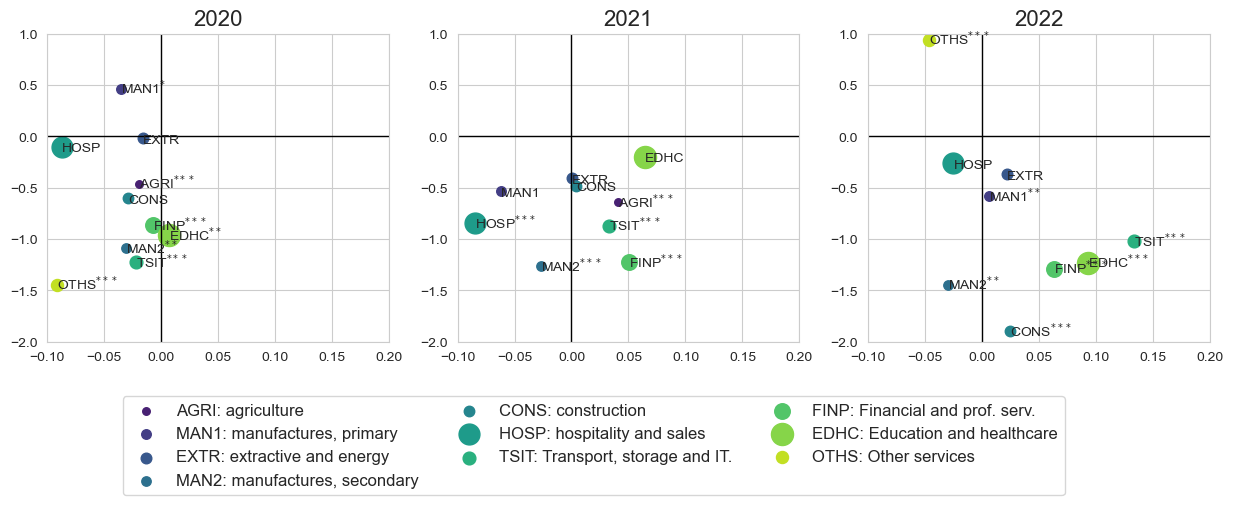

In [191]:
colors = sn.color_palette('viridis',10)
ind_acronyms = ['AGRI','MAN1','EXTR','MAN2','CONS','HOSP','TSIT','FINP','EDHC','OTHS']
color_dict = dict(zip(industry_dict.values(),colors))
size_dict = dict(zip(industry_dict.values(),1000*av_19/np.sum(av_19)))
acro_dict = dict(zip(industry_dict.values(),ind_acronyms))
plt.figure(figsize=(15,4))
for i,year in enumerate([2020,2021,2022]):
    plt.subplot(131+i)
    plt.title(year,fontsize=16)
    for ind in tab_dummies_f.loc[year,:].index:
        sig = significance_stars(tab_dummies_f.loc[(year,ind),'sig 25'])
        plt.scatter(tab_e_ind_change19_rel_y.loc[year,ind],float(tab_dummies_f.loc[(year,ind),'Parents, 25th pctl']),
                    color=color_dict[ind],s=size_dict[ind],label=acro_dict[ind]+": "+ind)
        plt.annotate(acro_dict[ind]+sig,
                     xy=(tab_e_ind_change19_rel_y.loc[year,ind],float(tab_dummies_f.loc[(year,ind),'Parents, 25th pctl'])-0.05))
    plt.ylim(-2,1)
    plt.xlim(-0.1,0.2)
    plt.axvline(c='k',lw=1)
    plt.axhline(c='k',lw=1)
    if year == 2020:
        plt.legend(ncol=3,fontsize=12,bbox_to_anchor=(3.,-0.15))
# plt.tight_layout()
plt.show()

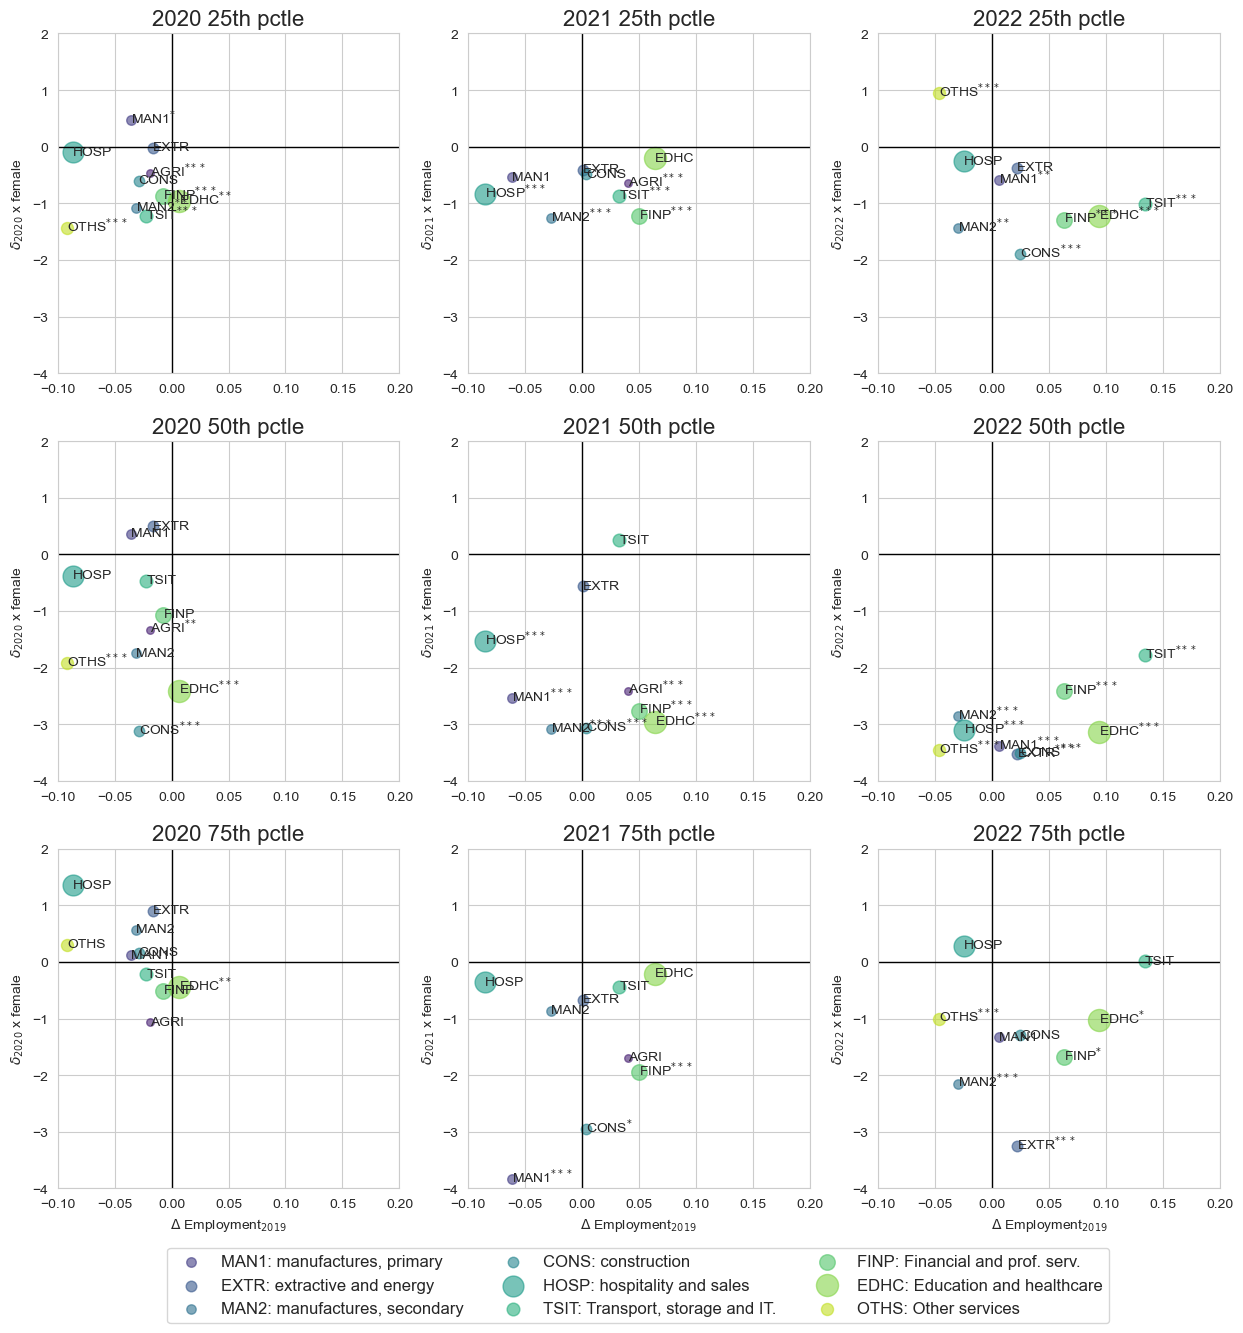

In [230]:
sn.set_palette('tab10',10)
plt.figure(figsize=(15,15))
for j,pct in enumerate([25,50,75]):
    for i,year in enumerate([2020,2021,2022]):
        xx = 331+i+(j*3)
        plt.subplot(xx)
        plt.title(str(year)+" {}th pctle".format(pct),fontsize=16)
        for ind in tab_dummies_f.loc[year,:].index:
            sig = significance_stars(tab_dummies_f.loc[(year,ind),'sig {}'.format(pct)])
            plt.scatter(tab_e_ind_change19_rel_y.loc[year,ind],
                        float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),color=color_dict[ind],
                        s=size_dict[ind],label=acro_dict[ind]+": "+ind,alpha=0.6)
            plt.annotate(acro_dict[ind]+sig,xy=(tab_e_ind_change19_rel_y.loc[year,ind],
                                                float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)])-0.05))
        plt.ylim(-4,2)
        plt.xlim(-0.1,0.2)
        plt.axvline(c='k',lw=1)
        plt.axhline(c='k',lw=1)
        plt.ylabel(r"$\delta_{"+str(year)+"}$ x female")
        if xx >336:
            plt.xlabel(r'$\Delta$ Employment$_{2019}$')
plt.legend(fontsize=12,ncol=3,bbox_to_anchor=(.7,-0.15))
plt.savefig('./plots_stocks/scatter_indE_mother_penalty.pdf',format='pdf',bbox_inches='tight')
plt.show()

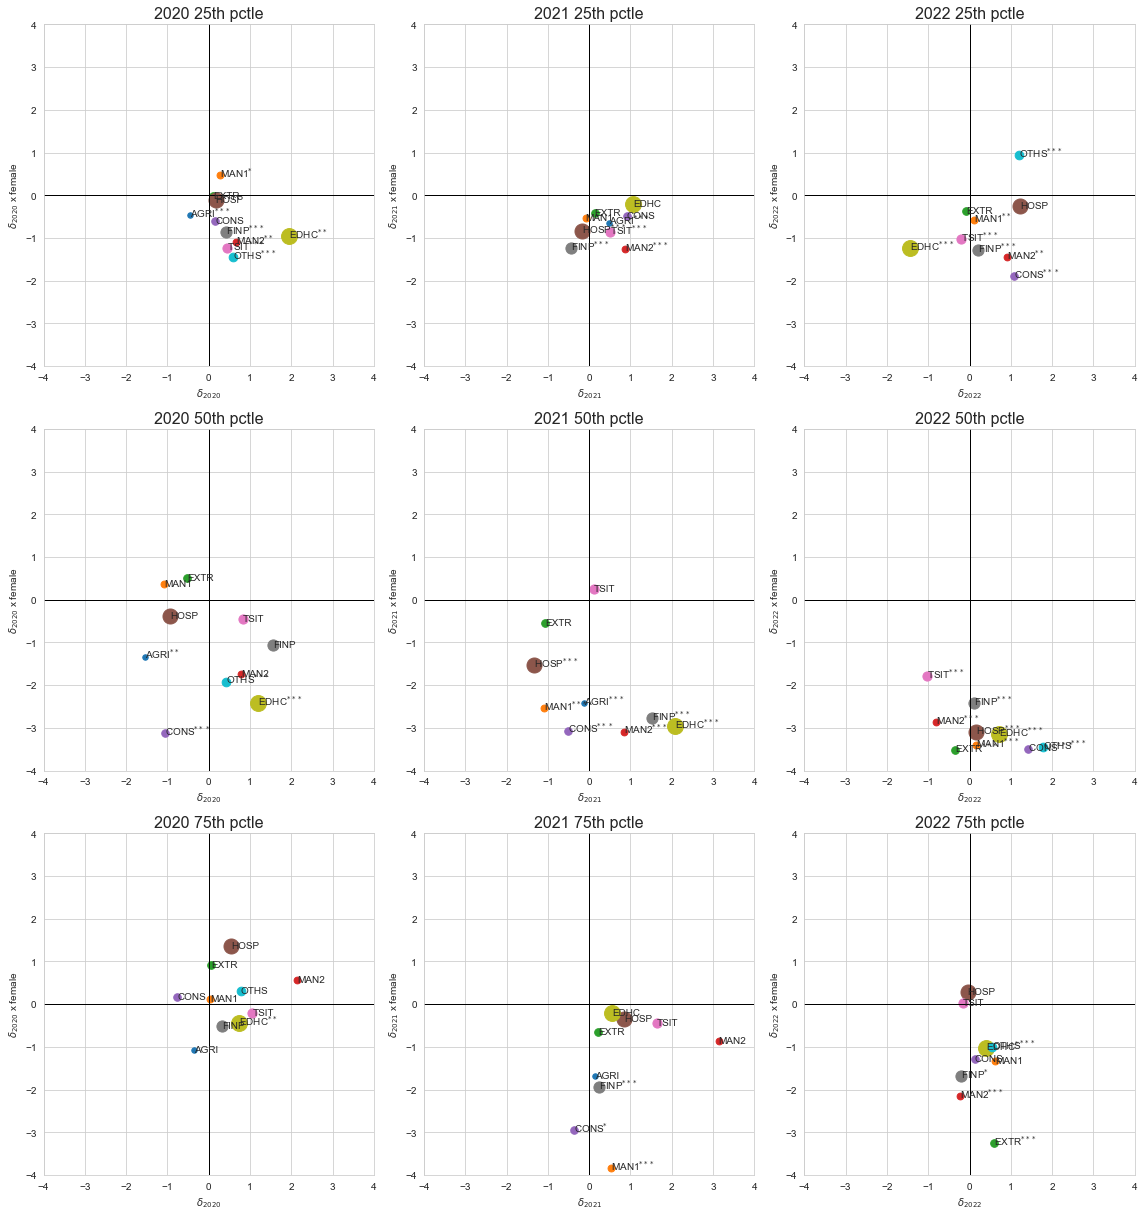

In [147]:
sn.set_palette('tab10',10)
plt.figure(figsize=(16,17))
for j,pct in enumerate([25,50,75]):
    for i,year in enumerate([2020,2021,2022]):
        xx = 331+i+(j*3)
        plt.subplot(xx)
        plt.title(str(year)+" {}th pctle".format(pct),fontsize=16)
        for ind in tab_dummies_f.loc[year,:].index:
            sig = significance_stars(tab_dummies_f.loc[(year,ind),'sig {}'.format(pct)])
            plt.scatter(float(tab_dummies.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),
                        float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),color=color_dict[ind],
                        s=size_dict[ind],label=acro_dict[ind]+": "+ind)
            plt.annotate(acro_dict[ind]+sig,xy=(float(tab_dummies.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),
                                                 float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)])-0.05))
        plt.ylim(-4,4)
        plt.xlim(-4,4)
        plt.axvline(c='k',lw=1)
        plt.axhline(c='k',lw=1)
        plt.xlabel(r"$\delta_{"+str(year)+"}$")
#         if xx >336:
        plt.ylabel(r"$\delta_{"+str(year)+"}$ x female")
# plt.legend(fontsize=12,ncol=3,bbox_to_anchor=(1.,-0.2))
plt.tight_layout()
plt.savefig('./plots_stocks/scatter_indE_mother_father_dummies.pdf',format='pdf',bbox_inches='tight')
plt.show()

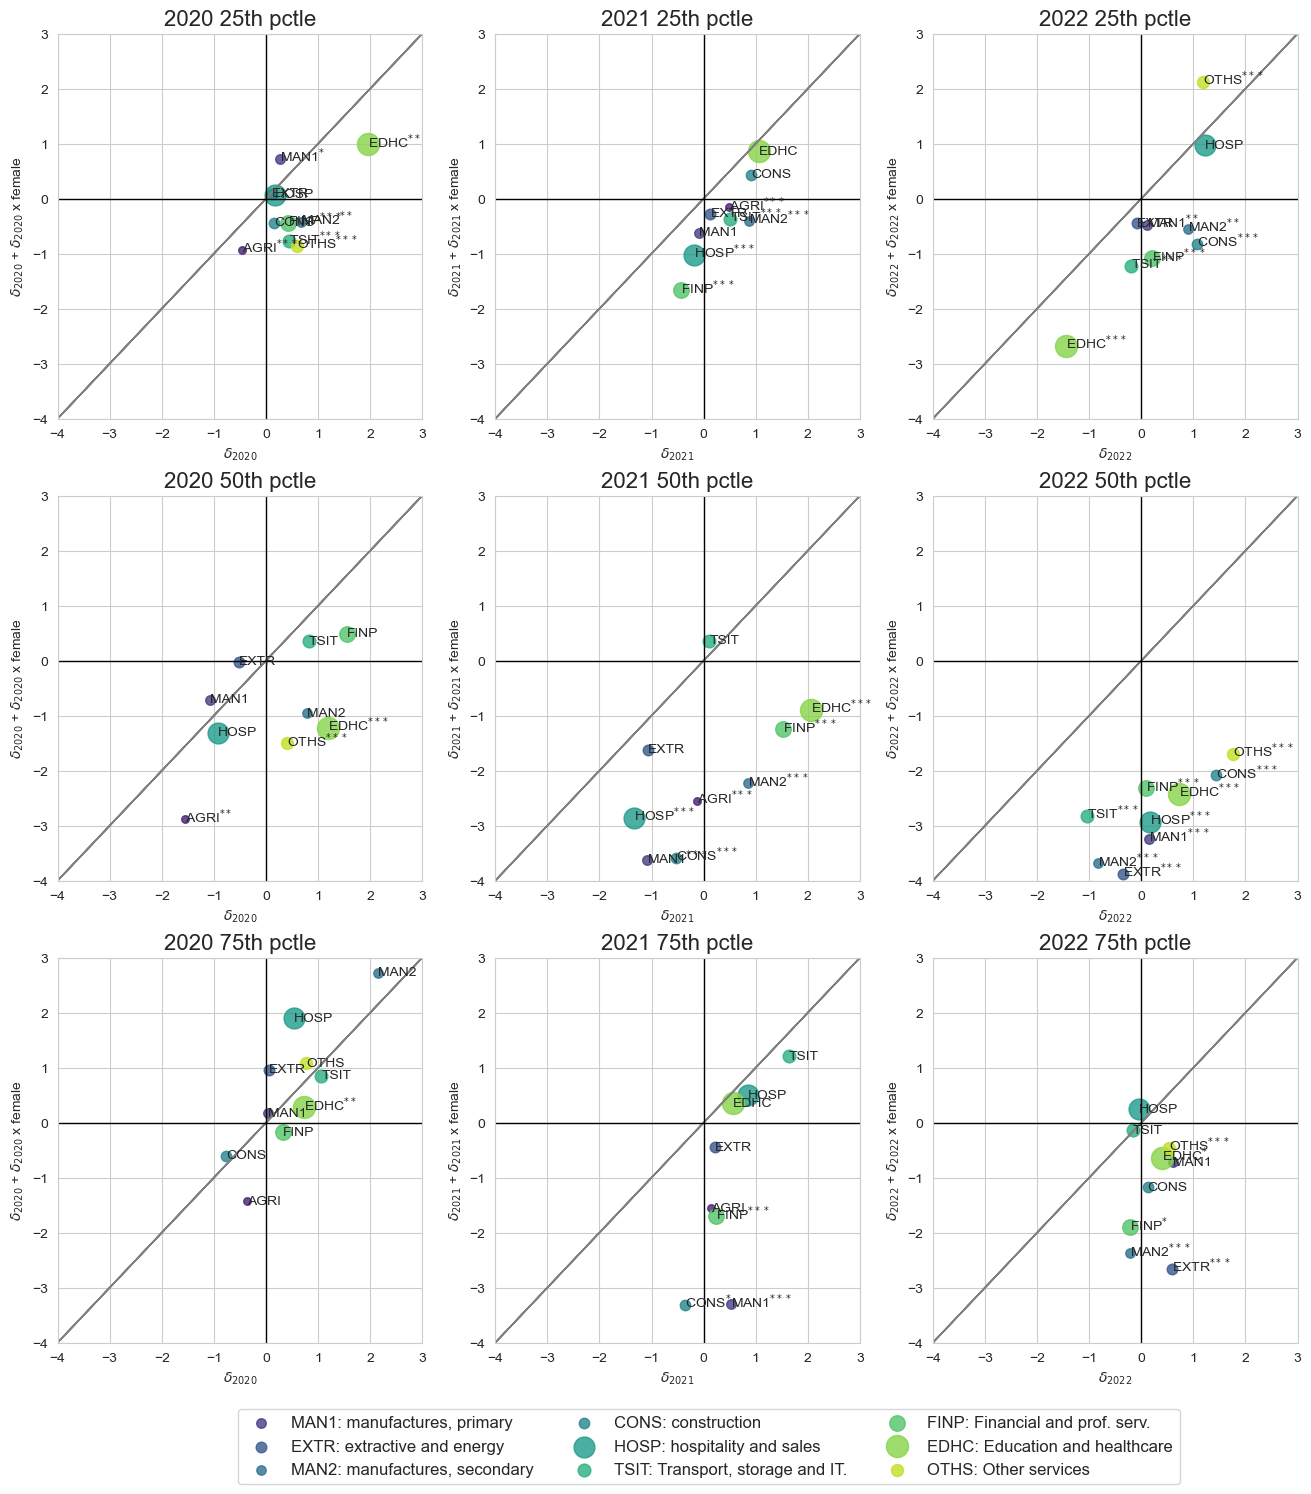

In [222]:
sn.set_palette('viridis',10)
plt.figure(figsize=(16,17))
for j,pct in enumerate([25,50,75]):
    for i,year in enumerate([2020,2021,2022]):
        xx = 331+i+(j*3)
        plt.subplot(xx)
        plt.title(str(year)+" {}th pctle".format(pct),fontsize=16)
        for ind in tab_dummies_f.loc[year,:].index:
            sig = significance_stars(tab_dummies_f.loc[(year,ind),'sig {}'.format(pct)])
            base_point = float(tab_dummies.loc[(year,ind),'Parents, {}th pctl'.format(pct)])
            plt.scatter(base_point,base_point+float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),
                        color=color_dict[ind],s=size_dict[ind],label=acro_dict[ind]+": "+ind,alpha=0.8)
            plt.annotate(acro_dict[ind]+sig,
                         xy=(base_point,base_point+float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)])-0.05))
            plt.plot([-4,3],[-4,3], color='grey',lw=1)
        plt.ylim(-4,3)
        plt.xlim(-4,3)
        plt.axvline(c='k',lw=1)
        plt.axhline(c='k',lw=1)
        plt.xlabel(r"$\delta_{"+str(year)+"}$")
#         if xx >336:
        plt.ylabel(r"$\delta_{"+str(year)+"}$ + "+r"$\delta_{"+str(year)+"}$ x female")
plt.legend(fontsize=12,ncol=3,bbox_to_anchor=(.7,-0.15))
# plt.tight_layout()
plt.savefig('./plots_stocks/scatter_indE_mother_father_dummies45.pdf',format='pdf',bbox_inches='tight')
plt.show()

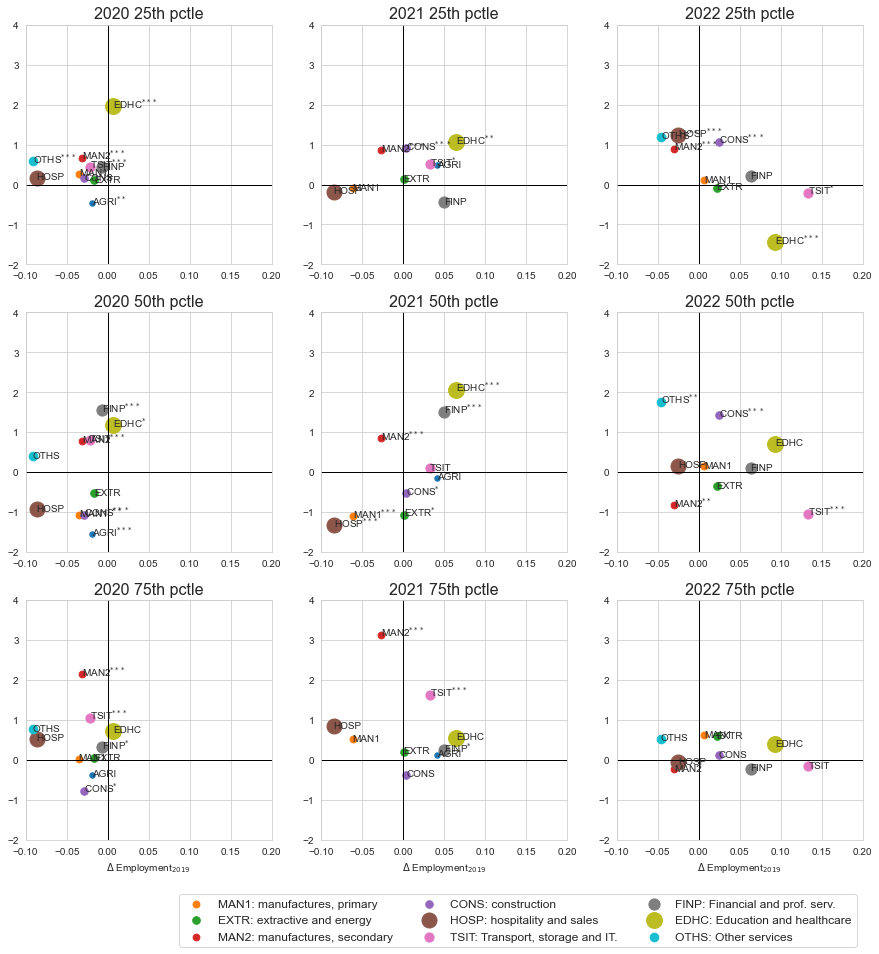

In [160]:
sn.set_palette('tab10',10)
plt.figure(figsize=(15,15))
for j,pct in enumerate([25,50,75]):
    for i,year in enumerate([2020,2021,2022]):
        xx = 331+i+(j*3)
        plt.subplot(xx)
        plt.title(str(year)+" {}th pctle".format(pct),fontsize=16)
        for ind in tab_dummies.loc[year,:].index:
            sig = significance_stars(tab_dummies.loc[(year,ind),'sig {}'.format(pct)])
            plt.scatter(tab_e_ind_change19_rel_y.loc[year,ind],
                        float(tab_dummies.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),color=color_dict[ind],
                        s=size_dict[ind],label=acro_dict[ind]+": "+ind)
            plt.annotate(acro_dict[ind]+sig,xy=(tab_e_ind_change19_rel_y.loc[year,ind],
                                                float(tab_dummies.loc[(year,ind),'Parents, {}th pctl'.format(pct)])-0.05))
        plt.ylim(-2,4)
        plt.xlim(-0.1,0.2)
        plt.axvline(c='k',lw=1)
        plt.axhline(c='k',lw=1)
        if xx >336:
            plt.xlabel(r'$\Delta$ Employment$_{2019}$')
plt.legend(fontsize=12,ncol=3,bbox_to_anchor=(1.,-0.2))
plt.savefig('./plots_stocks/scatter_indE.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [240]:
path = 'descriptive_stats/'

name = 'temp_ind_emp_husbands_age3040_w'
file_split(name+'.log',path,startwords=['ciclo',],endword="Total",header=None)

tab_t_ind_1 = read_table(path+name+'_1.log',keyword='ciclo',rescale=100,ncols=7)
tab_t_ind_2 = read_table(path+name+'_2.log',keyword='ciclo',rescale=100,ncols=3)
tab_t_ind = pd.concat((tab_t_ind_1,tab_t_ind_2),axis=1)
tab_t_ind.rename(columns=industry_dict,inplace=True)
tab_t_ind.rename(index=date_dict,inplace=True)
tab_t_ind.head()

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2005Q1,24370.21,17233.96,30898.29,16432.98,165562.16,45402.84,26605.66,18648.57,44188.53,13717.15
2005Q2,26876.32,16461.63,33299.86,17107.38,174502.76,56336.34,24833.43,21062.42,45386.82,19526.79
2005Q3,33647.12,19907.25,36628.24,16763.64,190258.06,60719.33,25853.42,17983.79,43007.51,20399.57
2005Q4,33508.55,27029.21,34831.46,16847.06,194988.70,67169.27,29666.13,18460.09,44707.27,15014.48
2006Q1,26334.76,25474.29,38562.08,27082.21,217545.19,53153.39,29923.60,17886.05,42842.75,12870.98


In [246]:
tab_t_ind_diff = tab_t_ind.iloc[4:,:].values-tab_t_ind.iloc[:-4,:].values
tab_t_ind_diff =pd.DataFrame(tab_t_ind_diff,index=tab_t_ind.index[4:],columns=tab_t_ind.keys())
tab_t_ind_diff

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2006Q1,1964.55,8240.33,7663.79,10649.23,51983.03,7750.55,3317.94,-762.52,-1345.78,-846.17
2006Q2,-433.24,4985.71,8719.95,10406.28,48807.26,552.75,1869.19,-3354.57,2438.50,-4512.58
2006Q3,-11974.26,124.17,2551.59,10226.63,30827.60,-3643.22,-143.40,5437.99,5316.49,-5404.07
2006Q4,-4537.96,-9193.71,3647.35,8988.11,33678.27,-6626.03,-1504.81,6229.38,1341.35,283.66
2007Q1,-279.93,-4788.73,172.53,-3468.05,12929.17,-12092.53,-1748.87,3559.24,67.14,1315.71
...,...,...,...,...,...,...,...,...,...,...
2021Q4,1068.80,1902.32,6941.88,-5249.11,3123.20,-2414.79,-6465.24,-4948.12,-10271.56,1189.45
2022Q1,-9707.43,1557.96,2200.74,-3515.03,1803.93,-5499.91,-4493.14,-756.65,-6760.91,2195.58
2022Q2,-9185.14,-5995.17,595.19,-4731.14,-8510.58,4983.20,940.75,2076.69,469.78,3471.64
2022Q3,-12900.92,-8628.03,-7025.11,-3052.31,-13997.51,-17063.37,-683.90,-4752.28,-4226.06,-3088.67


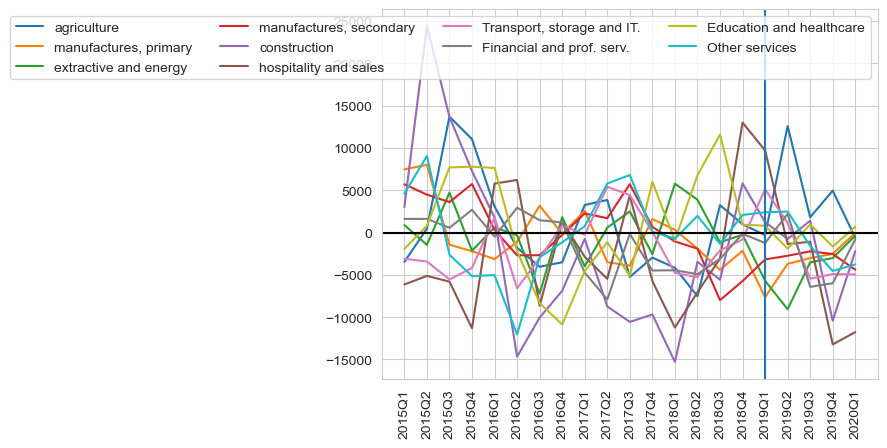

In [256]:
for ind in tab_t_ind_diff.keys():
    plt.plot(tab_t_ind_diff.loc['2015Q1':'2020Q1',ind],label=ind)
plt.xticks(rotation=90)
plt.axhline(c='k')
plt.axvline('2019Q1')
plt.legend(ncol=4)
plt.show()

In [258]:
path = 'descriptive_stats/'

name = 'perm_ind_emp_husbands_age3040_w'
file_split(name+'.log',path,startwords=['ciclo',],endword="Total",header=None)

tab_p_ind_1 = read_table(path+name+'_1.log',keyword='ciclo',rescale=100,ncols=7)
tab_p_ind_2 = read_table(path+name+'_2.log',keyword='ciclo',rescale=100,ncols=3)
tab_p_ind = pd.concat((tab_p_ind_1,tab_p_ind_2),axis=1)
tab_p_ind.rename(columns=industry_dict,inplace=True)
tab_p_ind.rename(index=date_dict,inplace=True)


tab_p_ind_diff = tab_p_ind.iloc[4:,:].values-tab_p_ind.iloc[:-4,:].values
tab_p_ind_diff =pd.DataFrame(tab_p_ind_diff,index=tab_p_ind.index[4:],columns=tab_p_ind.keys())
tab_p_ind_diff

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2006Q1,4315.84,-2302.36,4360.12,-10114.85,359.17,9258.11,-17286.68,4706.53,-9662.52,7157.13
2006Q2,2787.23,-633.28,16030.69,-1912.40,2972.57,2181.07,-16548.40,-1712.53,-8131.54,7420.37
2006Q3,5488.74,-3016.06,17975.19,-13055.99,-5579.98,2147.47,4693.79,-10378.84,-24599.77,7121.76
2006Q4,-5925.35,-1468.54,8477.85,1667.78,-1592.08,1016.66,-9459.10,-11757.57,-12912.47,-3805.26
2007Q1,-4068.56,919.82,8387.90,9788.31,8675.39,-7454.86,23976.55,9284.82,-9149.61,-10521.98
...,...,...,...,...,...,...,...,...,...,...
2021Q4,-13100.40,-89.98,-346.73,-12175.22,-15530.96,-27918.83,16694.39,4426.72,-7410.16,3429.32
2022Q1,-4304.81,11806.36,-6170.70,-8653.49,-13547.25,-8526.90,3043.94,-11280.11,1822.47,10180.58
2022Q2,-3690.31,15332.23,-2778.89,-753.26,7005.64,1460.47,9394.58,-9065.41,-1231.39,7515.61
2022Q3,3382.90,23441.10,-4052.68,-6893.32,15582.71,11841.17,18774.07,-9812.30,15097.36,4650.44


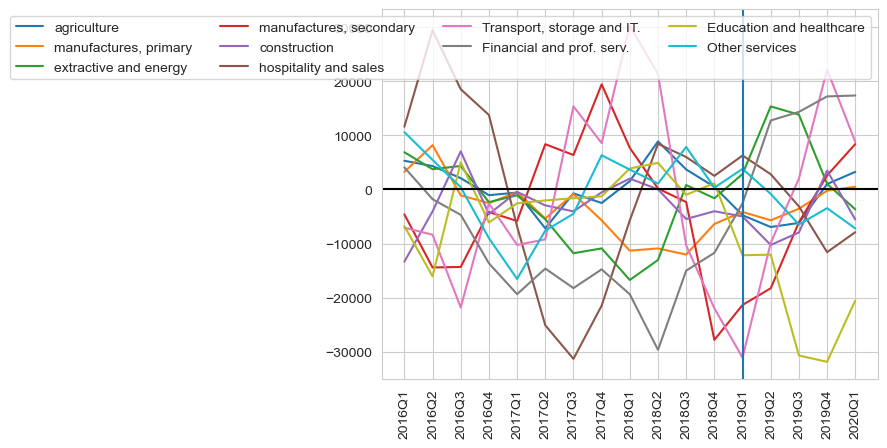

In [259]:
for ind in tab_p_ind_diff.keys():
    plt.plot(tab_p_ind_diff.loc['2016Q1':'2020Q1',ind],label=ind)
plt.xticks(rotation=90)
plt.axhline(c='k')
plt.axvline('2019Q1')
plt.legend(ncol=4)
plt.show()